# Signature Forgery Detection

---

<br>

Lab: P4 <br>
Group: 16 <br>
Team Members:
1. Gerald Tan Liang Chee (2303173)
2. Jovan Lim Yu Hang (2303397)
3. Lim Jing Yu (2303001)
4. Nigel Lim Wei Siang (2302942)
5. Rachel Wan Jing Mun (2303024)
6. Ranson Chong Sian Sen (2303174)

# 1. Problem Statement and Data Collection

explainn.... signature fraud issues (if can with concrete statistics(?)), cedar dataset

# 2. Data Processing, Feature Extraction,  and Analysis

---

## 2.1 Data Pre-Processing

utilised the make_pair public notebook, describe the changes we made. the steps taken to preprocess. then our final data x and y

In [37]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import seaborn as sns
import pandas as pd
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from skimage.measure import shannon_entropy
from skimage.filters import gabor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [33]:
# 🔹 Step 1: Preprocess Individual Images
def preprocess_image(image):
    # Ensure image is valid
    if image is None:
        raise ValueError("Received an invalid image (None). Check file paths or input data.")

    # Convert to grayscale only if the image is not already grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Ensure image is in uint8 format
    image = np.uint8(image)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Adaptive Histogram Equalization (CLAHE) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    # Apply Edge Detection (Canny)
    edges = cv2.Canny(enhanced, 50, 150)

    # Apply Binary Thresholding
    _, thresholded = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresholded


In [34]:
# 🔹 Step 2: Pair Genuine & Forged Signatures
def make_pairs(genuine, forged):
    """Creates (genuine, genuine) and (genuine, forged) signature pairs using preprocessed images."""
    
    gen_gen_pairs = [[t[0], t[1]] for t in itertools.combinations(genuine, 2)]
    gen_forg_pairs_temp = [[t[0], t[1]] for t in itertools.product(genuine, forged)]

    gen_gen_pairs = np.array(gen_gen_pairs)
    gen_forg_pairs_temp = np.array(gen_forg_pairs_temp)

    # Pick same number of (genuine, forged) pairs as (genuine, genuine)
    gen_forg_indices = random.sample(range(len(gen_forg_pairs_temp)), len(gen_gen_pairs))
    gen_forg_pairs = np.array([gen_forg_pairs_temp[i] for i in gen_forg_indices])

    return gen_gen_pairs, gen_forg_pairs

## 2.2 Feature Extraction

In [35]:
# 🔹 Step 3: Extract Features (Edge, Intensity, Texture)

def extract_features(image):
    """Extract edge-based, texture-based, and intensity-based features from a preprocessed image."""
    features = []
    feature_labels = []  # To store the names of extracted features
    
    # Edge
    # ✅ Step 1: Apply Gaussian Blur to reduce noise before edge detection
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # ✅ Step 2: Compute Sobel Gradients (Edge Magnitude & Orientation)
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
    edge_magnitude = np.sqrt(sobelx**2 + sobely**2)  # Gradient magnitude
    edge_orientation = np.arctan2(sobely, sobelx)  # Gradient angle in radians

    # ✅ Step 3: Compute Histogram of Edge Magnitude (Avoiding Only 0 and 255)
    edge_mag_hist, _ = np.histogram(edge_magnitude, bins=32, range=(0, np.max(edge_magnitude)))
    features.extend(edge_mag_hist)
    feature_labels.extend([f"Edge_Mag_Hist_{i}" for i in range(32)])

    # ✅ Step 4: Compute Histogram of Edge Orientation (Edge Direction)
    edge_orient_hist, _ = np.histogram(edge_orientation, bins=16, range=(-np.pi, np.pi))
    features.extend(edge_orient_hist)
    feature_labels.extend([f"Edge_Orient_Hist_{i}" for i in range(16)])

    # ✅ Texture-based (Gabor Filters)
    frequencies = [0.1, 0.2, 0.3]  # Different frequencies
    orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Different angles
    
    for freq in frequencies:
        for theta in orientations:
            gabor_res, _ = gabor(image, frequency=freq, theta=theta)
            features.append(np.mean(gabor_res))  # Mean response
            features.append(np.var(gabor_res))   # Variance response
            feature_labels.append(f"Gabor_Mean_{freq}_{theta}")
            feature_labels.append(f"Gabor_Var_{freq}_{theta}")

    # ✅ Intensity-based (CLAHE)
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(image)

    # Compute Entropy (measures complexity)
    entropy = shannon_entropy(enhanced)

    # Compute Variance (measures intensity spread)
    variance = np.var(enhanced)

    # ✅ Append Intensity Features
    features.extend([entropy, variance])
    feature_labels.extend(["CLAHE_Entropy", "CLAHE_Variance"])
    
    return np.array(features), feature_labels

## 2.3 Normalisation

In [ ]:
# 🔹 Step 4: Normalize & Standardize Pairs

def normalize_features(X):
    """Applies different scaling methods for different feature types."""
    
    feature_length = X.shape[-1]  # Number of features
    X_reshaped = X.reshape(-1, feature_length)  # Flatten for scaling

    # Define the index ranges of each feature type
    edge_indices = list(range(48))  # Edge Magnitude & Orientation
    texture_indices = list(range(48, 72))  # Gabor Features
    intensity_indices = list(range(72, 74))  # CLAHE Features (Entropy & Variance)

    # MinMaxScaler for Edge Features
    scaler_edge = MinMaxScaler()
    X_reshaped[:, edge_indices] = scaler_edge.fit_transform(X_reshaped[:, edge_indices])

    # StandardScaler for Texture Features
    scaler_texture = StandardScaler()
    X_reshaped[:, texture_indices] = scaler_texture.fit_transform(X_reshaped[:, texture_indices])

    # RobustScaler for Intensity Features
    scaler_intensity = RobustScaler()
    X_reshaped[:, intensity_indices] = scaler_intensity.fit_transform(X_reshaped[:, intensity_indices])

    return X_reshaped.reshape(X.shape)  # Reshape back to original format


## 2.4 Processing the data

In [37]:
# 🔹 Step 5: Prepare Data Pipeline
def prepare_data(genuine, forged, X, y):
    """Prepares training data by preprocessing images, generating pairs, extracting features, and normalizing."""
    
    # ✅ Preprocess images BEFORE pairing
    genuine = np.array([preprocess_image(img) for img in genuine])
    forged = np.array([preprocess_image(img) for img in forged])

    # Step 2: Pair images
    gen_gen_pairs, gen_forg_pairs = make_pairs(genuine, forged)

    # Step 3: Extract features from pairs
    gen_gen_features = np.array([[extract_features(pair[0])[0], extract_features(pair[1])[0]] for pair in gen_gen_pairs])
    gen_forg_features = np.array([[extract_features(pair[0])[0], extract_features(pair[1])[0]] for pair in gen_forg_pairs])

    all_pairs = np.concatenate((gen_gen_features, gen_forg_features), axis=0)
    print(f"All pairs shape: {all_pairs.shape}")  # Should be (num_pairs, 2, feature_length)

    # Labels (1 for genuine-genuine pairs, 0 for genuine-forged pairs)
    labels = np.concatenate((np.ones(gen_gen_pairs.shape[0]), np.zeros(gen_forg_pairs.shape[0])), axis=0)
    print(f"Labels shape: {labels.shape}")  # Should match the number of pairs

    # Step 4: Apply Standard Scaling
    all_pairs = normalize_features(all_pairs)

    # Shuffle Data
    combined = list(zip(all_pairs, labels))
    random.shuffle(combined)
    shuffled_pairs, shuffled_labels = zip(*combined)

    X[:] = shuffled_pairs
    y[:] = shuffled_labels

In [ ]:
# 🔹 Step 6: Load and Process Dataset
parent_path = "archive/signatures/"

width = 200
height = 150
num_sig = 55
feature_length = 74  # Number of extracted features per signature
X = np.zeros((num_sig * 2 * 276, 2, feature_length), dtype=np.float32)
y = np.zeros((num_sig * 2 * 276), dtype=np.float32)

m = 0
for ind in range(1, num_sig+1):

    print(f"Iteration number {m+1}")
    genuine = np.zeros((24, height, width), dtype=np.uint8)
    forged = np.zeros((24, height, width), dtype=np.uint8)

    path = os.path.join(parent_path, f"signatures_{ind}")

    i = 0
    j = 0
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        if os.path.isfile(image_path):
          img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
          img = 255 - img
          img = cv2.resize(img, (width, height))
          if i < 24 and image.startswith("original"):
            genuine[i] = img
            i += 1
          elif j < 24 and image.startswith("forgeries"):
            forged[j] = img
            j += 1

    #prepare_data(genuine, forged, X_train, y_train, m)
    prepare_data(genuine, forged, X[m*552:(m+1)*552], y[m*552:(m+1)*552])
    m += 1


print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

Iteration number 1


KeyboardInterrupt: 

In [ ]:
np.save("X.npy", X)  # Saves in the current directory
np.save("y.npy", y)  # Saves in the current directory

## 2.5 Data Analysis and Visualisation

C:\Users\User\AppData\Local\Temp\ipykernel_46628\423972675.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df[:20], x="Importance", y="Feature", palette="viridis")


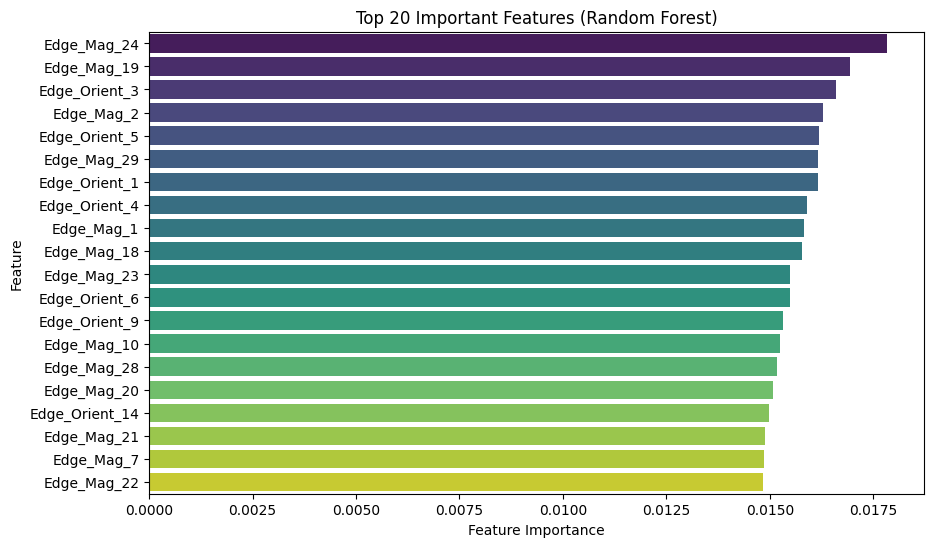

In [ ]:
# Load X and y
X = np.load("X.npy", allow_pickle=True)
y = np.load("y.npy", allow_pickle=True)

# Define feature labels
feature_labels = (
    [f"Edge_Mag_{i}" for i in range(32)] +
    [f"Edge_Orient_{i}" for i in range(16)] +
    [f"Gabor_Mean_{freq}_{theta}" for freq in [0.1, 0.2, 0.3] for theta in [0, np.pi/4, np.pi/2, 3*np.pi/4]] +
    [f"Gabor_Var_{freq}_{theta}" for freq in [0.1, 0.2, 0.3] for theta in [0, np.pi/4, np.pi/2, 3*np.pi/4]] +
    ["CLAHE_Entropy", "CLAHE_Variance"]
)

# Convert X into a DataFrame
df_X = pd.DataFrame(X[:, 0, :], columns=feature_labels)
df_y = pd.Series(y, name="Forgery Label")

# 🔹 Feature Importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_X, df_y)

# Get feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({"Feature": feature_labels, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 🔹 Plot Feature Importance Heatmap
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df[:20], x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

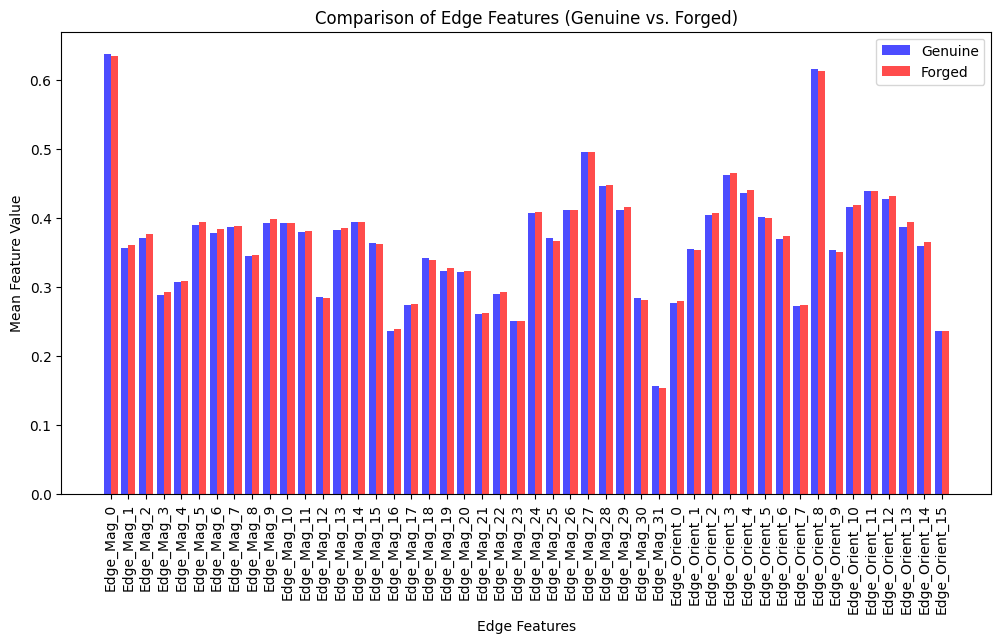

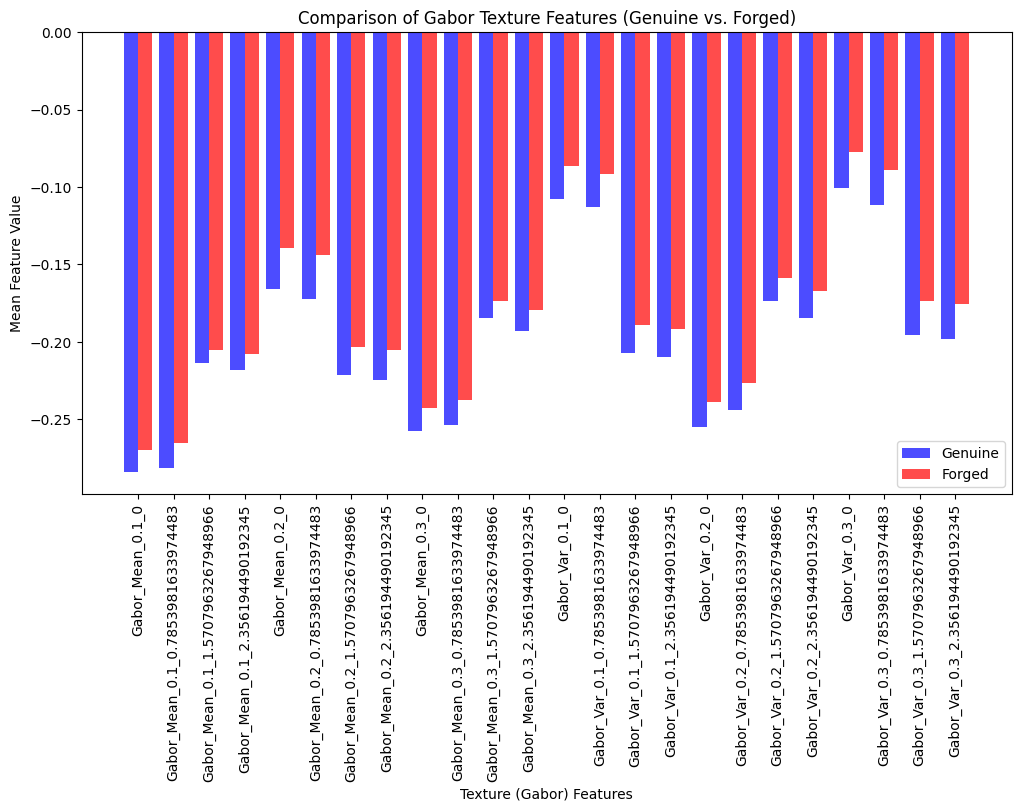

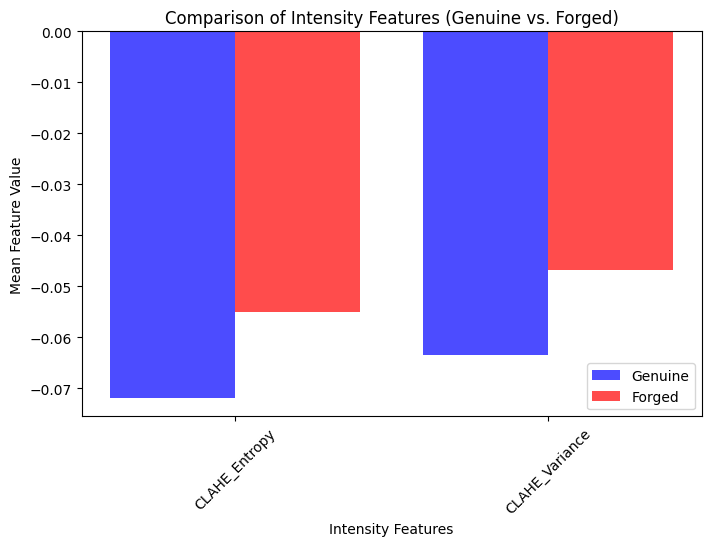

In [ ]:
# Convert X into a DataFrame
df_X = pd.DataFrame(X[:, 0, :], columns=feature_labels)
df_y = pd.Series(y, name="Forgery Label")

# Separate genuine and forged samples
df_X["Forgery Label"] = df_y
df_genuine = df_X[df_X["Forgery Label"] == 1].drop(columns=["Forgery Label"])
df_forged = df_X[df_X["Forgery Label"] == 0].drop(columns=["Forgery Label"])

# Splitting Edge, Texture, and Intensity Features
edge_features = [col for col in feature_labels if "Edge_Mag" in col or "Edge_Orient" in col]
texture_features = [col for col in feature_labels if "Gabor_Mean" in col or "Gabor_Var" in col]
intensity_features = ["CLAHE_Entropy", "CLAHE_Variance"]

# 🎯 **Plot Edge Features**
plt.figure(figsize=(12, 6))
genuine_means = df_genuine[edge_features].mean()
forged_means = df_forged[edge_features].mean()

plt.bar(np.arange(len(genuine_means)) - 0.2, genuine_means, width=0.4, label="Genuine", alpha=0.7, color='blue')
plt.bar(np.arange(len(forged_means)) + 0.2, forged_means, width=0.4, label="Forged", alpha=0.7, color='red')

plt.xticks(ticks=np.arange(len(genuine_means)), labels=genuine_means.index, rotation=90)
plt.xlabel("Edge Features")
plt.ylabel("Mean Feature Value")
plt.title("Comparison of Edge Features (Genuine vs. Forged)")
plt.legend()
plt.show()

# 🎯 **Plot Texture Features (Gabor Filters)**
plt.figure(figsize=(12, 6))
genuine_means = df_genuine[texture_features].mean()
forged_means = df_forged[texture_features].mean()

plt.bar(np.arange(len(genuine_means)) - 0.2, genuine_means, width=0.4, label="Genuine", alpha=0.7, color='blue')
plt.bar(np.arange(len(forged_means)) + 0.2, forged_means, width=0.4, label="Forged", alpha=0.7, color='red')

plt.xticks(ticks=np.arange(len(genuine_means)), labels=genuine_means.index, rotation=90)
plt.xlabel("Texture (Gabor) Features")
plt.ylabel("Mean Feature Value")
plt.title("Comparison of Gabor Texture Features (Genuine vs. Forged)")
plt.legend()
plt.show()

# 🎯 **Plot Intensity Features (CLAHE)**
plt.figure(figsize=(8, 5))
genuine_means = df_genuine[intensity_features].mean()
forged_means = df_forged[intensity_features].mean()

plt.bar(np.arange(len(genuine_means)) - 0.2, genuine_means, width=0.4, label="Genuine", alpha=0.7, color='blue')
plt.bar(np.arange(len(forged_means)) + 0.2, forged_means, width=0.4, label="Forged", alpha=0.7, color='red')

plt.xticks(ticks=np.arange(len(genuine_means)), labels=genuine_means.index, rotation=45)
plt.xlabel("Intensity Features")
plt.ylabel("Mean Feature Value")
plt.title("Comparison of Intensity Features (Genuine vs. Forged)")
plt.legend()
plt.show()

# 3. Experiment design and machine learning algorithm implementation

### **Experiment Design Plan**

To evaluate the effectiveness of different machine learning models in detecting signature forgery, we designed a structured experimental workflow. The CEDAR Signature paired dataset will be split into 70% training and 30% validation, ensuring that the models are trained and fine-tuned before final evaluation. Additionally, a custom real-world test set, consisting of 11 individuals' signatures (approximately 20% of the total CEDAR dataset size), will be used for final testing to assess the model’s generalization to real-world data.
<br><br>
We will train and compare three machine learning models: Support Vector Machine (SVM), Random Forest, and XGBoost. These models were chosen for their ability to handle different types of data structures and classification tasks effectively.

*   SVM is well-suited for high-dimensional feature spaces and is known for its strong performance in binary classification problems.
*   Random Forest, an ensemble learning method, provides robustness by combining multiple decision trees to reduce overfitting and improve generalization.
*   XGBoost, a gradient boosting technique, is included due to its efficiency, scalability, and ability to capture complex patterns in data.

Together, these models allow for a diverse evaluation of classical machine learning approaches in signature forgery detection.
<br><br>
The experiment will be conducted in three phases.

1. Train a baseline model for each algorithm using default hyperparameters and evaluate their initial performance on the validation set.
2. Fine-tune each model by adjusting hyperparameters to optimize their performance.
3. Re-evaluate the models on the validation set to measure improvements.

.<br>
Following these evaluations, we will compare all three tuned models across key performance metrics such as accuracy, precision, recall, F1-score, and ROC-AUC score. The best-performing model, based on validation results, will then be selected for final testing on the custom real-world test set. This approach ensures that our model selection is based on systematic evaluation and that the chosen model is validated on unseen real-world signature samples before deployment.
<br><br>
Lastly, the chosen model will be compared to an existing deep learning model *(Siamese Network)* to assess how classical machine learning models perform relative to deep learning approaches in signature forgery detection. This final comparison will help determine the trade-offs in accuracy, efficiency, and interpretability between both methods.

In [ ]:
# 🔹 Load Training Data
X = np.load("X.npy", allow_pickle=True)
y = np.load("y.npy", allow_pickle=True)

# Convert to 2D (Flatten pairs)
X = X.reshape(X.shape[0], -1)  # Reshape to (num_samples, num_features)

## 3.1 Model #1: SVM

### 3.1.1 Initial Training of Model #1

Model Training

In [4]:
# 🔹 Split into 70% Training and 30% Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 🔹 Feature Scaling (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training
X_val = scaler.transform(X_val)  # Transform validation set

# 🔹 Train SVM Model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Model Evaluation

In [5]:
# 🔹 Evaluate on Validation Set
y_val_pred = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"🔹 Validation Accuracy: {val_accuracy:.4f}")

🔹 Validation Accuracy: 0.8412


In [6]:
# 🔹 Classification Report (Validation Set)
print("\n🔹 Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=["Forged", "Genuine"]))


🔹 Classification Report (Validation Set):
              precision    recall  f1-score   support

      Forged       0.86      0.82      0.84      4554
     Genuine       0.83      0.86      0.84      4554

    accuracy                           0.84      9108
   macro avg       0.84      0.84      0.84      9108
weighted avg       0.84      0.84      0.84      9108



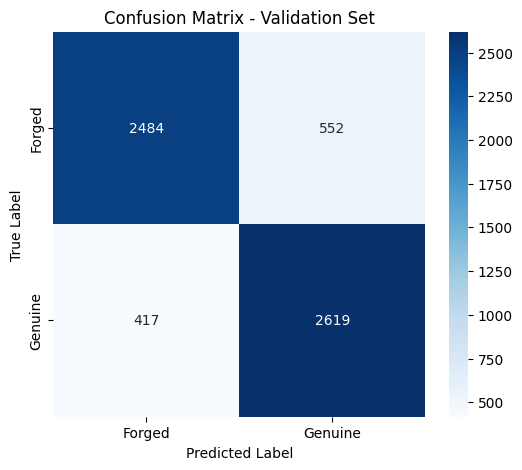

In [ ]:
# 🔹 Confusion Matrix (Validation Set)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap="Blues", xticklabels=["Forged", "Genuine"], yticklabels=["Forged", "Genuine"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()

### 3.1.2 Performance After Tuning Model #1

Model Training

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  # Kernel coefficient
}

# Initialize SVM model
svm_model = SVC()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

Model Evaluation

In [8]:
# Get best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}, 0.9901185326635946)

In [10]:
# Save the trained SVM model
# Use best model found from Grid Search
best_svm = grid_search.best_estimator_

# Define model path
model_dir = "models"
model_path = os.path.join(model_dir, "svm_signature_model.joblib")

# ✅ Check if the directory exists, if not, create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# ✅ Save the trained SVM model
dump(best_svm, model_path)

print(f"Model saved successfully at: {model_path}")


Model saved successfully at: models\svm_signature_model.joblib


In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Compute permutation importance
perm_importance = permutation_importance(best_svm, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

# Sort feature importance scores
sorted_indices = np.argsort(perm_importance.importances_mean)[::-1]
sorted_features = [feature_labels[i] for i in sorted_indices]
sorted_importance = perm_importance.importances_mean[sorted_indices]

# Plot top 10 important features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features[:10], sorted_importance[:10], color='blue')
plt.xlabel("Permutation Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features (Permutation Importance)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Print top 10 features
for i in range(10):
    print(f"{sorted_features[i]}: {sorted_importance[i]:.4f}")


## 3.2 Model #2: Random Forest

### 3.2.1 Initial Training of Model #2

Model Training

In [38]:
# 🔹 Split into 70% Training and 30% Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 🔹 Feature Scaling (Standardization) - Not strictly necessary for Random Forest, but keeping it for consistency
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training
X_val = scaler.transform(X_val)  # Transform validation set

# 🔹 Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Model Evaluation

In [39]:
# 🔹 Evaluate on Validation Set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"🔹 Validation Accuracy: {val_accuracy:.4f}")

🔹 Validation Accuracy: 0.9974


In [40]:
# 🔹 Classification Report (Validation Set)
print("\n🔹 Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=["Forged", "Genuine"]))


🔹 Classification Report (Validation Set):
              precision    recall  f1-score   support

      Forged       1.00      1.00      1.00      4554
     Genuine       1.00      1.00      1.00      4554

    accuracy                           1.00      9108
   macro avg       1.00      1.00      1.00      9108
weighted avg       1.00      1.00      1.00      9108



/Users/jingyu/Documents/GitHub/MLProject/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


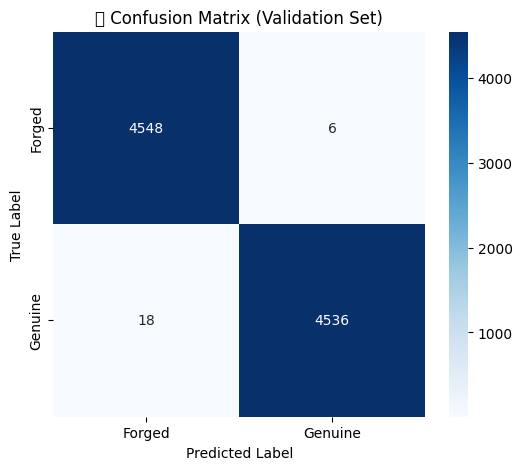

In [41]:
# 🔹 Generate Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Forged", "Genuine"], yticklabels=["Forged", "Genuine"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🔹 Confusion Matrix (Validation Set)")
plt.show()

### 3.2.2 Performance After Tuning Model #2

Model Training

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# 🔹 Define Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [10, 20, None],          # Depth of each tree
    'min_samples_split': [2, 5, 10],      # Min samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Min samples required at a leaf node
    'criterion': ['gini', 'entropy'],     # Splitting criterion
}

# 🔹 Initialize Random Forest Model
rf = RandomForestClassifier(random_state=42)

# 🔹 Grid Search with Cross-Validation
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2
)

# 🔹 Train the Model with Best Parameters
grid_search.fit(X_train, y_train)

# 🔹 Best Parameters & Best Model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"🔹 Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.9s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.9s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.2s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  44.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  45.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  45.2s
[

Model Evaluation

🔹 Fine-Tuned Validation Accuracy: 0.9982

🔹 Classification Report (Validation Set):
              precision    recall  f1-score   support

      Forged       1.00      1.00      1.00      4554
     Genuine       1.00      1.00      1.00      4554

    accuracy                           1.00      9108
   macro avg       1.00      1.00      1.00      9108
weighted avg       1.00      1.00      1.00      9108



/Users/jingyu/Documents/GitHub/MLProject/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


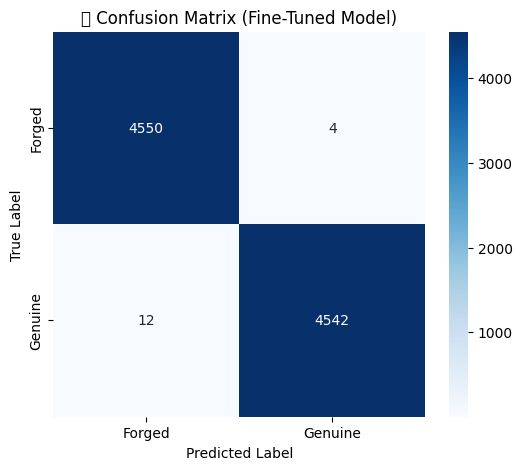

✅ Model saved successfully as 'random_forest_model.pkl'


In [43]:
import joblib

# 🔹 Evaluate Best Model on Validation Set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"🔹 Fine-Tuned Validation Accuracy: {val_accuracy:.4f}")

# 🔹 Classification Report
print("\n🔹 Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=["Forged", "Genuine"]))

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Forged", "Genuine"], yticklabels=["Forged", "Genuine"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🔹 Confusion Matrix (Fine-Tuned Model)")
plt.show()

joblib.dump(best_model, "random_forest_model.pkl")
print("✅ Model saved successfully as 'random_forest_model.pkl'")

In [46]:
import numpy as np
import time
import os
import psutil
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import dump

# 🔹 Compute Mutual Information Scores
mi_scores = mutual_info_classif(X, y)

# 🔹 Sort Features by Importance
sorted_indices = np.argsort(mi_scores)[::-1]  # Descending order
top_k = 35  # Select top 35 features
selected_indices = sorted_indices[:top_k]

# 🔹 Filter X to Keep Only Selected Features
X_selected = X[:, selected_indices]

# 🔹 Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y
)

# 🔹 Apply Standard Scaling (Optional for Random Forest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 🔹 Train Random Forest on Selected & Scaled Features with Timing
rf_selected = RandomForestClassifier(
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

# 🔹 Measure Training Time
start_train = time.time()
rf_selected.fit(X_train_scaled, y_train)
end_train = time.time()

# 🔹 Measure Testing Time
start_test = time.time()
y_val_pred = rf_selected.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
end_test = time.time()

# 🔹 Save Model and Get File Size
os.makedirs("models", exist_ok=True)  # Ensure 'models' directory exists
dump(rf_selected, "models/rf_final.joblib")
model_size = os.path.getsize("models/rf_final.joblib") / 1024  # Convert to KB

# 🔹 Check Memory Usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / 1024 / 1024  # Convert to MB

# 🔹 Print Model Performance & System Metrics
print("🔹 Model Performance & System Metrics 🔹")
print(f"✅ Train Accuracy: {rf_selected.score(X_train_scaled, y_train):.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")
print(f"📌 Training Time: {end_train - start_train:.4f} seconds")
print(f"📌 Testing Time: {end_test - start_test:.4f} seconds")
print(f"📌 Model Size: {model_size:.2f} KB")
print(f"📌 Memory Usage: {memory_usage:.2f} MB")

🔹 Model Performance & System Metrics 🔹
✅ Train Accuracy: 1.0000
✅ Validation Accuracy: 0.9992
📌 Training Time: 12.0451 seconds
📌 Testing Time: 0.2942 seconds
📌 Model Size: 17117.34 KB
📌 Memory Usage: 147.11 MB


## 3.3 Model #3: XGBoost

### 3.3.1 Initial Training of Model #3

Model Training

Model Evaluation

In [ ]:
# Save RandomForest model
#dump(rf_model, "models/randomforest_model.joblib")

### 3.3.2 Performance After Tuning Model #3

Model Training

Model Evaluation

In [ ]:
# Save XGBoost model
#dump(xgb_model, "models/xgboost_model.joblib")

## 3.4 Comparison of Tuned Models Across Different Algorithms

Chosen Model: ______

# 4. Experiment Results & Analysis

## 4.1 Evaluation of the Chosen Model on Test Data

In [ ]:
# Load the SVM model
#svm_model = load("svm_model.joblib")

## 4.2 Comparison of Our Model's Performance with an Existing Deep Learning Model

use the deeep learning model - siam_network to predict on our test data.<br>
compare the performance between our model and the siam_network.<br>
coz siam_network claimed to be 100% accurate, if the siam_network's accuracy and the other performance matrices are close/similar to our model. then we are gooood.